# 1.  Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectPercentile, chi2
from sklearn.metrics import recall_score, roc_curve, roc_auc_score, classification_report, confusion_matrix

# 2. Defaults

In [2]:
seed = 12 # 12 ears
y = 'OverallPoF' # target
dataset_dir = '00 - Dataset/03 - Sampling Splits/'

# library options
plt.rcParams[ 'figure.figsize' ] = (16, 9) # larger plots
plt.rcParams[ 'font.size' ] = '16' # larger fonts
pd.set_option('display.max_colwidth', None) # print evth in pd df


# cv parameters
cv_params = {
    'cv': 10, # k-fold
    'n_jobs': -1, # use all cpu cores
    'error_score': 0,
    'scoring': 'f1_macro',
    'return_train_score': True
}

# classifier parameters
base_params = {
    'dual': False,
    'random_state': seed,
    'max_iter': 23220451 * 12,
    'class_weight': 'balanced'
}

# pipeline parameters
hyper_params = {
    'classifier__C': [ 0.01, 0.1, 1, 10, 100 ],
    'f_selector__max_features': [ None, 7, 11, 13 ],
    'f_selector__threshold': [ 
        None,
        '1.00 * mean', '1.25 * mean', '1.50 * mean', '1.75 * mean', 
        '2.00 * mean', '2.25 * mean', '2.50 * mean', '2.75 * mean', 
        '3.00 * mean', '3.25 * mean', '3.50 * mean', '3.75 * mean',
        '4.00 * mean', '4.25 * mean', '4.50 * mean', '4.75 * mean',
    ],
}

# 3. Datasets

In [3]:
datasets = { }
for sample in next(os.walk(dataset_dir))[ 1 ]:
    sample_name = sample.split(' - ')[ 1 ]
    sample_dir = dataset_dir + sample + '/'
    
    # X
    X_train = pd.read_csv(sample_dir + 'X_train.csv')
    X_val = pd.read_csv(sample_dir + 'X_val.csv')
    X_test = pd.read_csv(sample_dir + 'X_test.csv')
    
    # y
    y_train = pd.read_csv(sample_dir + 'y_train.csv')[ y ]
    y_val = pd.read_csv(sample_dir + 'y_val.csv')[ y ]
    y_test = pd.read_csv(sample_dir + 'y_test.csv')[ y ]
    
    # absorbance only
    X_train = X_train.filter(regex = r'fa[0-9]*')
    X_val = X_val.filter(regex = r'fa[0-9]*')
    X_test = X_test.filter(regex = r'fa[0-9]*')
    
    datasets[ sample_name ] = {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test,
    }

# 4. Functions

In [4]:
def ttest_refit(cv_results):
    splits = set([ 
        k.split('_')[ 0 ] for k in cv_results.keys() if k.startswith('split') 
    ])
    n_folds = len(cv_results[ 'params' ])
    
    # ttest significance whether train/test means differ
    significance = [ ]
    for i in range(n_folds):
        train_scores = [ ]
        test_scores = [ ]
        
        for split in splits:
            train_score = cv_results[ split + '_train_score' ][ i ]
            test_score = cv_results[ split + '_test_score' ][ i ]
            
            train_scores.append(train_score)
            test_scores.append(test_score)
        
        _, pvalue = stats.ttest_ind(
            train_scores, 
            test_scores,
            equal_var = False
        )
        
        if (pvalue > 0.05):
            significance.append(False)
        else:
            significance.append(True)
    
    # use cv's #1 rank as default index
    ranking = list(cv_results[ 'rank_test_score' ])
    chosen_idx = ranking.index(1)
    
    # loop through ranking to get non overfit best score
    for rank in sorted(ranking):
        idx = ranking.index(rank)
        if (significance[ idx ]):
            continue
        chosen_idx = idx
        break
        
    return chosen_idx

def sd_refit(cv_results):
    train_scores = list(cv_results[ 'mean_train_score' ])
    train_sd = list(cv_results[ 'std_train_score' ])
    test_scores = list(cv_results[ 'mean_test_score' ])
    test_sd = list(cv_results[ 'std_test_score' ])
    ranking = list(cv_results[ 'rank_test_score' ])
    
    significance = [ ]
    for i in range(len(train_sd)):
        train_bound = train_scores[ i ] - 2 * train_sd[ i ]
        test_bound = test_scores[ i ] + 2 * test_sd[ i ]
        sig = True
        if (test_bound >= train_bound):
            sig = False
        significance.append(sig)
        
    # use cv's #1 rank as default index
    chosen_idx = ranking.index(1)
    
    # loop through ranking to get non overfit best score
    for rank in sorted(ranking):
        idx = ranking.index(rank)
        if (significance[ idx ]):
            continue
        chosen_idx = idx
        break
    
    return chosen_idx

def diff_refit(cv_results):
    alpha = 0.05 # 5%
    train_scores = list(cv_results[ 'mean_train_score' ])
    test_scores = list(cv_results[ 'mean_test_score' ])
    ranking = list(cv_results[ 'rank_test_score' ])
    
    # use cv's #1 rank as default index
    chosen_idx = ranking.index(1)
    
    # loop through ranking to get non overfit best score
    for rank in sorted(ranking):
        idx = ranking.index(rank)
        diff = abs(train_scores[ idx ] - test_scores[ idx ])
        if (diff < 0.05):
            chosen_idx = idx
            break
            
    return chosen_idx

def extract_frequencies(columns):
    return ', '.join([ c[ 2 :  ] for c in columns ])

def conf_plot(y_true, y_pred):
    cf_matrix = confusion_matrix(y_true = y_true, y_pred = y_pred)
    cf_flatten = cf_matrix.flatten()
    labels = [ 'TN','FP','FN','TP' ]
    counts = [ 
        '{0:0.0f}'.format(value) for value in cf_flatten
    ]
    percents = [ 
        '{0:.2%}'.format(value/ np.sum(cf_matrix)) for value in cf_flatten
    ]
    annots = [
        f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(labels, counts, percents)
    ]
    
    ax = sns.heatmap(
        fmt = '', 
        cbar = False,
        cmap = 'Blues',
        data = cf_matrix, 
        annot = np.asarray(annots).reshape(2, 2)
    )
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels([ 'negative', 'positive' ])
    ax.yaxis.set_ticklabels([ 'negative', 'positive' ])

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
def roc_all_split(clf, sample):
    plt.figure()
    dataset = datasets[ sample ]
    splits = {
        'train': (dataset[ 'X_train' ], dataset[ 'y_train' ]),
        'val': (dataset[ 'X_val' ], dataset[ 'y_val' ]),
        'test': (dataset[ 'X_test' ], dataset[ 'y_test' ]),
    }

    for s in splits:
        X, y_true = splits[ s ]
        y_score = clf.decision_function(X)
        
        auc = roc_auc_score(y_true = y_true, y_score = y_score)
        fpr, tpr, _ = roc_curve(y_true = y_true, y_score = y_score)
        plt.plot(fpr, tpr, label = '%s (area = %0.2f)' % (s, auc))
    
    plt.plot([ 0, 1 ], [ 0, 1 ],'r--')
    plt.xlim([ 0.0, 1.0 ])
    plt.ylim([ 0.0, 1.01 ])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc = 'lower right')
    plt.show()
    
def plot_contributions(pipe, frequencies):
    clf = pipe[ 'classifier' ]
    print(clf.coef_)
    coef_plot = pd.Series(
        data = abs(clf.coef_[ 0 ]), 
        index = [ f for f in frequencies.split(', ') ]
    ).sort_values().plot(kind = 'barh')
    coef_plot.set_title('Frequencies\' Contribution')
    
def plot_correlation(columns, annot = True):
    corr = round(abs(X_train[ columns ].corr(method = 'pearson')), 2)
    
    mask = np.zeros_like(corr)
    mask[ np.triu_indices_from(mask) ] = True
    
    sns.heatmap(
        corr,
        cbar = False,
        mask = mask, 
        linewidths = .5, 
        annot_kws = { 'fontsize': 'small' },
        center = 0, 
        annot = True, 
        cmap = 'flare'
    )

def plot_absorbance(frequencies):
    full_data = pd.read_csv('00 - Dataset/02 - Cleaning Results/a_data.csv')
    full_data = full_data[ list(full_data.filter(regex = r'f[0-9]+').columns) + [ y ] ]
    
    full_data[ 'id' ] = full_data.index
    long_data = pd.wide_to_long(
        df = full_data,
        stubnames = [ 'f' ],
        i = 'id',
        j = 'frequencies'
    ).rename(columns = { 'f': 'absorbance' }).reset_index().iloc[  : , 1 :  ]

    plt.figure()
    chart = sns.lineplot(data = long_data, x = 'frequencies', y = 'absorbance', hue = 'OverallPoF')
    ymin, ymax = chart.get_ylim()
    _, xmax = chart.get_xlim()

    # vertical lines
    chart.vlines(
        x = [ int(f) for f in frequencies.split(', ') ], 
        ymin = ymin, 
        ymax = ymax, 
        ls = '--', 
        lw = 2,
        colors = 'red'
    )
    plt.xlim([ 0.0, xmax ])
    plt.ylim([ 0.0, ymax ])
    plt.show()
    
def plot_sample(sample_idx):
    full_data = pd.read_csv('00 - Dataset/02 - Cleaning Results/a_data.csv')
    full_data = full_data[ list(full_data.filter(regex = r'f[0-9]+').columns) + [ y ] ]

    X_sample = datasets[ 'Original' ][ 'X_test' ].iloc[[ sample_idx ]]
    y_sample = datasets[ 'Original' ][ 'y_test' ][ sample_idx ]
    
    test_sample = X_sample
    test_sample[ y ] = y_sample
    
    test_sample.columns = full_data.columns
    
    full_data = full_data[ full_data[ y ] == 0 ]

    test_sample[ 'split' ] = 'test sample ' + str(sample_idx)
    full_data[ 'split' ] = 'positive avg'
    
    full_data = full_data.append(test_sample)
    full_data = full_data.reset_index()
    
    full_data[ 'id' ] = full_data.index
    long_data = pd.wide_to_long(
        df = full_data,
        stubnames = [ 'f' ],
        i = 'id',
        j = 'frequencies'
    ).rename(columns = { 'f': 'absorbance' }).reset_index().iloc[  : , 1 :  ]

    plt.figure()
    chart = sns.lineplot(
        data = long_data, 
        x = 'frequencies', 
        y = 'absorbance', 
        hue = 'split'
    )
    ymin, ymax = chart.get_ylim()
    _, xmax = chart.get_xlim()

    plt.xlim([ 0.0, xmax ])
    plt.ylim([ 0.0, ymax ])
    plt.show()

# 5. Pipelines

In [5]:
pipelines = { }

## 5.1. L1

In [6]:
pipelines[ 'l1' ] = Pipeline([
    (
        'f_scaler', 
        StandardScaler()
    ),
    (
        'f_selector', 
        SelectFromModel(
            estimator = LinearSVC(**base_params, penalty = 'l1'),
        )
    ),
    (
        'classifier', 
        LinearSVC(**base_params)
    )
])

In [7]:
# pipelines[ 'l1_pipe' ].get_params()

## 5.2. L2

In [8]:
pipelines[ 'l2' ] = Pipeline([
    (
        'f_scaler', 
        StandardScaler()
    ),
    (
        'f_selector', 
        SelectFromModel(
            estimator = LinearSVC(**base_params),
        )
    ),
    (
        'classifier', 
        LinearSVC(**base_params)
    )
])

In [9]:
# pipelines[ 'l2_pipe' ].get_params()

# 6. Modelling

In [10]:
results = [ ] # container

In [11]:
for sample in datasets:
    X_train = datasets[ sample ][ 'X_train' ]
    y_train = datasets[ sample ][ 'y_train' ]
    X_val = datasets[ sample ][ 'X_val' ]
    y_val = datasets[ sample ][ 'y_val' ]
    
    for pipe in pipelines:
        grid = GridSearchCV(
            **cv_params,
            refit = ttest_refit,
            param_grid = hyper_params,
            estimator = pipelines[ pipe ],
        )
        grid.fit(X_train, y_train)
        
        f_selector = grid.best_estimator_[ 'f_selector' ]
        classifier = grid.best_estimator_[ 'classifier' ]
        
        columns = X_train.columns[ f_selector.get_support() ]
        
        train_auc = roc_auc_score(
            y_true = y_train, 
            y_score = grid.decision_function(X_train)
        )
        val_auc = roc_auc_score(
            y_true = y_val, 
            y_score = grid.decision_function(X_val)
        )
        
        og_train_recall = recall_score(
            average = 'macro',
            y_true = datasets[ 'Original' ][ 'y_train' ],
            y_pred = grid.best_estimator_.predict(datasets[ 'Original' ][ 'X_train' ])
        )
        train_recall = recall_score(
            average = 'macro',
            y_true = y_train,
            y_pred = grid.best_estimator_.predict(X_train)
        )
        val_recall = recall_score(
            average = 'macro',
            y_true = y_val,
            y_pred = grid.best_estimator_.predict(X_val)
        )
        
        results.append({
            'pipe': grid.best_estimator_,
            'columns': columns,
            'parameters': classifier.get_params(),
            'sample': sample,
            'regularisation': pipe,
            # 'threshold': f_selector.get_params()[ 'threshold' ],
            'n_features': len(columns),
            'frequencies': extract_frequencies(columns),
            # 'training_auc': round(train_auc * 100, 2),
            # 'validation_auc': round(val_auc * 100, 2),
            'training_recall': round(train_recall * 100, 2),
            # 'og_training_recall': round(og_train_recall * 100, 2),
            'validation_recall': round(val_recall * 100, 2)
        })

C:\ProgramData\Anaconda3\envs\dududev\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
860 fits failed out of a total of 3400.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\dududev\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\envs\dududev\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\envs\dududev\lib\site-packages\sklearn\svm\_classes.py", line 246, in fit
    X, y = 

C:\ProgramData\Anaconda3\envs\dududev\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
780 fits failed out of a total of 3400.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
340 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\dududev\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\envs\dududev\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\envs\dududev\lib\site-packages\sklearn\svm\_classes.py", line 246, in fit
    X, y = 

In [12]:
pd.DataFrame(results).iloc[  : , 3 :  ]

,sample,regularisation,n_features,frequencies,training_recall,validation_recall
0,Original,l1,11,"363, 1296, 1542, 1781, 3775, 4000, 4237, 4756, 4896, 5656, 5993",92.73,89.44
1,Original,l2,13,"514, 707, 727, 771, 793, 1542, 3775, 4000, 4117, 4237, 5495, 5656, 5993",91.19,73.33
2,NM2,l1,14,"385, 727, 971, 1296, 1587, 1834, 1887, 2310, 2747, 4000, 5039, 5495, 5993, 6727",79.55,77.78
3,NM2,l2,7,"363, 385, 1834, 4000, 5495, 5656, 5993",86.36,74.44
4,SMOTE,l1,21,"280, 363, 408, 727, 771, 943, 1296, 1542, 1781, 1943, 2996, 3363, 3775, 4000, 4237, 4756, 4896, 5495, 5656, 5993, 6535",92.31,87.78
5,SMOTE,l2,25,"280, 408, 432, 514, 577, 707, 727, 771, 793, 943, 1296, 1334, 1498, 1542, 2996, 3775, 4000, 4117, 4237, 4362, 4756, 4896, 5495, 5656, 5993",95.00,76.67
6,SMOTEENN,l1,14,"385, 577, 727, 1334, 1731, 2669, 2996, 3363, 4000, 4362, 4756, 5495, 5656, 5993",96.29,82.22
7,SMOTEENN,l2,22,"408, 727, 749, 771, 943, 1731, 2996, 3363, 3775, 4000, 4117, 4237, 4362, 4621, 4756, 4896, 5339, 5495, 5656, 5993, 7336, 8000",96.60,66.11
8,SMOTETomek,l1,12,"280, 408, 727, 1296, 1498, 1731, 2996, 3363, 4237, 4756, 5656, 5993",95.67,80.56
9,SMOTETomek,l2,13,"280, 727, 771, 1296, 1334, 1498, 2996, 4000, 4117, 4237, 5495, 5656, 5993",89.37,91.67


In [13]:
chosen_index = 9

# 7. Testing

In [14]:
chosen_row = results[ chosen_index ]
final_model = chosen_row[ 'pipe' ]

In [15]:
X_test = datasets[ 'Original' ][ 'X_test' ]
y_test = datasets[ 'Original' ][ 'y_test' ]

y_pred = final_model.predict(X_test)
y_true = y_test

## 7.1. Classification Report

In [16]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        41
           1       0.64      1.00      0.78         7

    accuracy                           0.92        48
   macro avg       0.82      0.95      0.86        48
weighted avg       0.95      0.92      0.92        48



## 7.2. Checking False Negatives

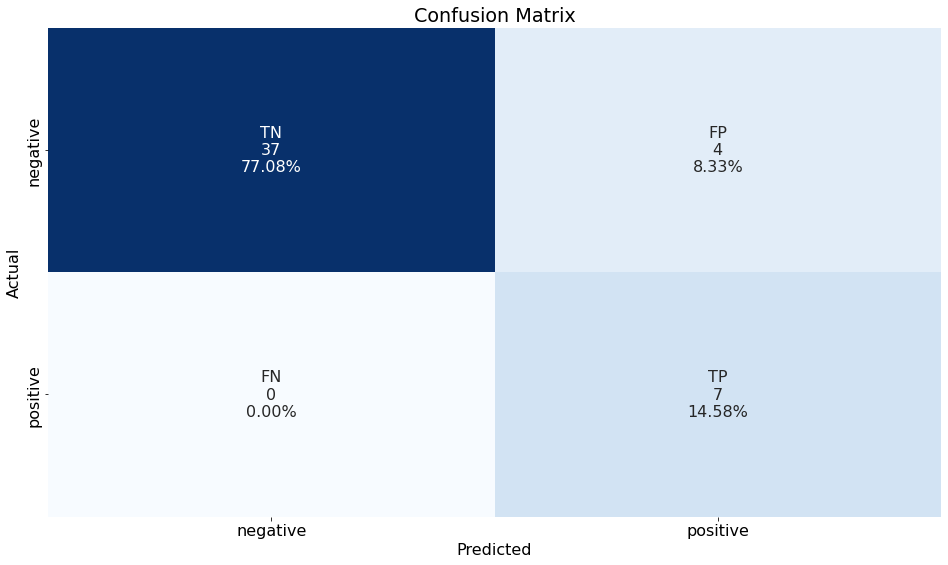

In [17]:
conf_plot(y_true = y_true, y_pred = y_pred)

## 7.3. Checking Overfitting

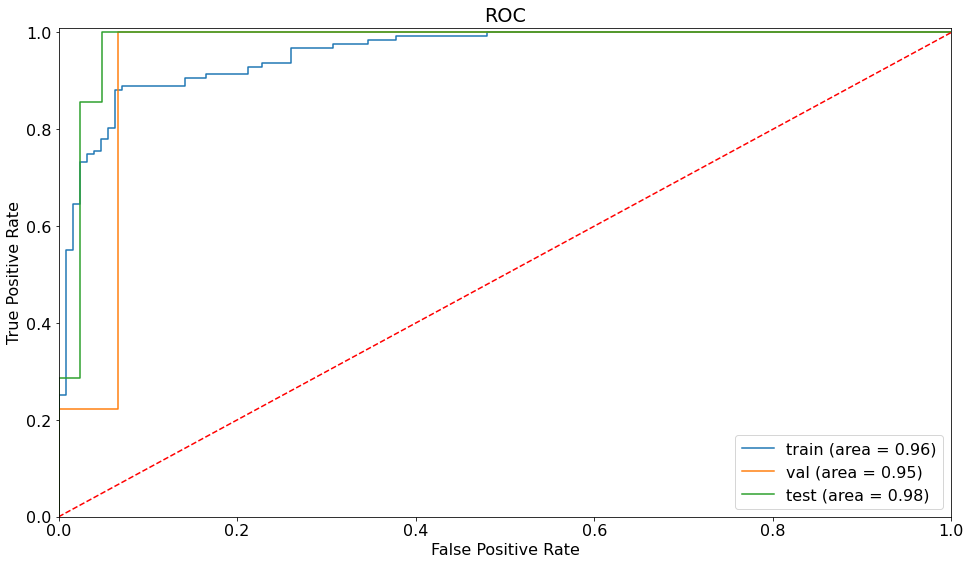

In [18]:
roc_all_split(clf = final_model, sample = chosen_row[ 'sample' ])

## 7.4. Frequency Ranking

[[ 0.0623638   0.65752231 -1.02282539 -1.49746715  0.99690885 -0.30000765
   0.32174679 -0.68127489 -1.6456197   1.834813    2.32155983 -4.35195591
   2.09839598]]


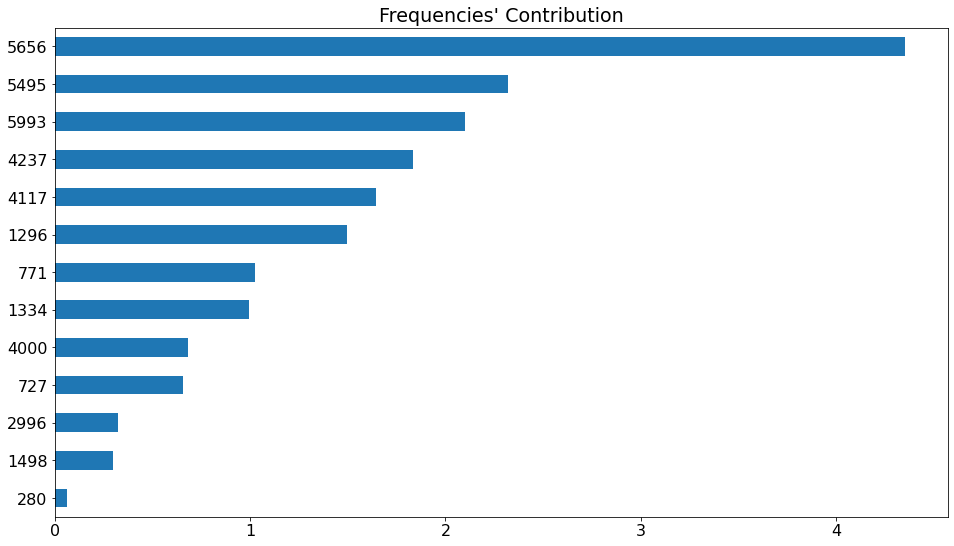

In [19]:
plot_contributions(
    pipe = final_model, 
    frequencies = chosen_row[ 'frequencies' ]
)

## 7.5. Checking Correlation

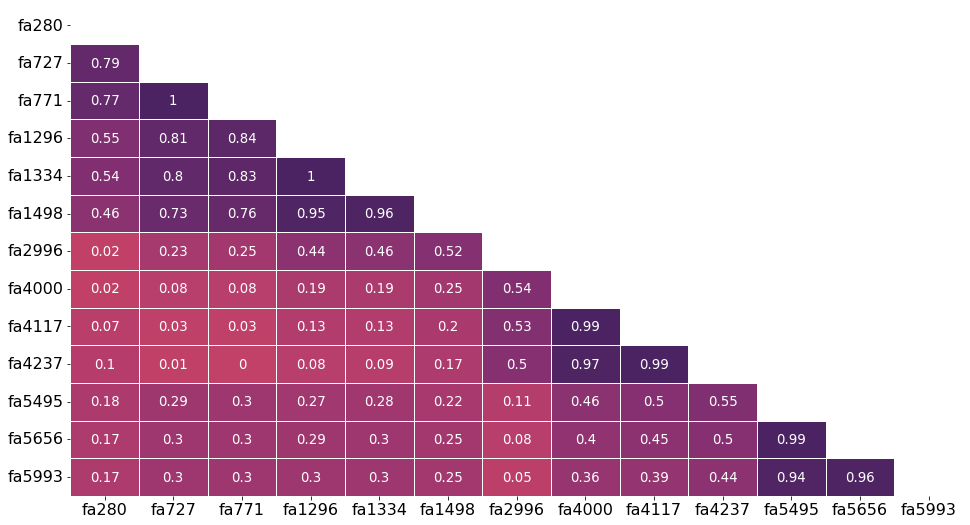

In [20]:
plot_correlation(columns = chosen_row[ 'columns' ])

## 7.6. The Chosen Frequencies

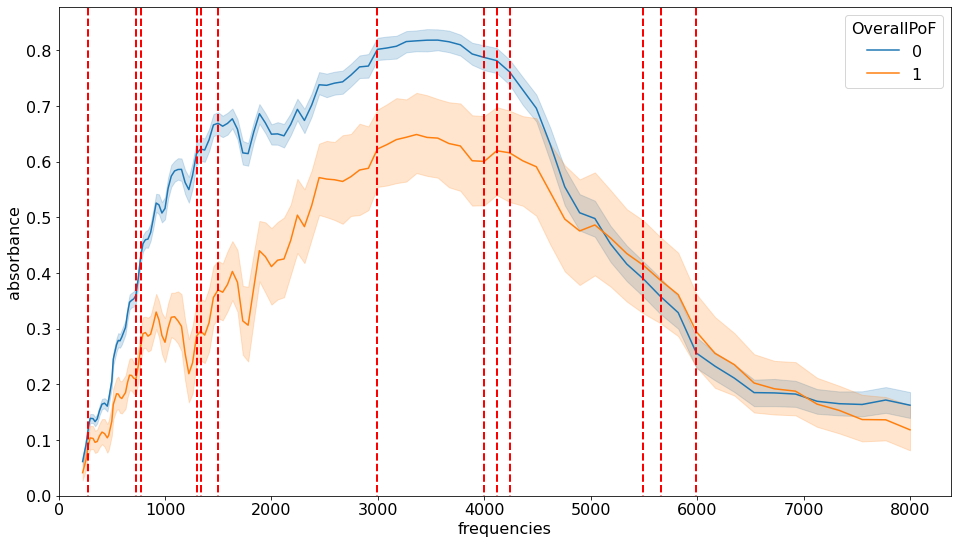

In [21]:
plot_absorbance(
    frequencies = chosen_row[ 'frequencies' ]
)

In [22]:
final_model[ 'classifier' ].get_params()

{'C': 100,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 278645412,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 12,
 'tol': 0.0001,
 'verbose': 0}

# 8. Explaining Results

## 8.1. Choose Test Sample

In [23]:
test_sample = 6

C:\Users\edkur\AppData\Local\Temp\ipykernel_7396\699128603.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample[ y ] = y_sample
C:\Users\edkur\AppData\Local\Temp\ipykernel_7396\699128603.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample[ 'split' ] = 'test sample ' + str(sample_idx)
C:\Users\edkur\AppData\Local\Temp\ipykernel_7396\699128603.py:227: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


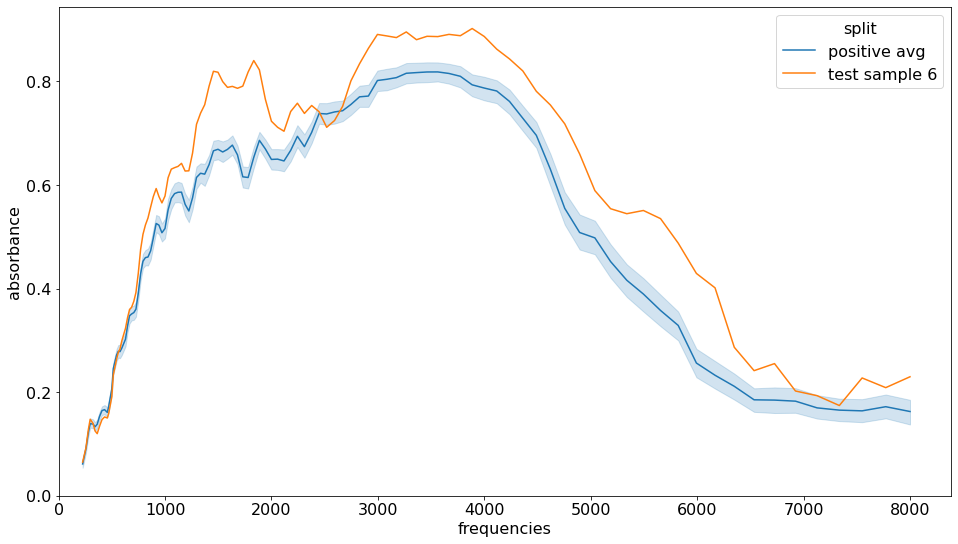

In [24]:
plot_sample(test_sample)

## 8.2. Actual Class vs Model Prediction

In [25]:
print('actual:', y_true[ test_sample ])

actual: 0


In [26]:
print('prediction:', y_pred[ test_sample ])

prediction: 0


## 8.3. X

In [27]:
X = X_test.iloc[[ test_sample ]][ chosen_row[ 'columns' ] ]
X

,fa280,fa727,fa771,fa1296,fa1334,fa1498,fa2996,fa4000,fa4117,fa4237,fa5495,fa5656,fa5993
6,0.1281,0.3926,0.4758,0.7172,0.7387,0.8177,0.8907,0.8867,0.8623,0.8434,0.5508,0.5351,0.4293


## 8.4. Standardise X

In [28]:
X = pd.DataFrame(
    final_model[ 'f_scaler' ].transform(X_test), 
    columns = X_test.columns
).iloc[[ test_sample ]][ chosen_row[ 'columns' ] ]
X

,fa280,fa727,fa771,fa1296,fa1334,fa1498,fa2996,fa4000,fa4117,fa4237,fa5495,fa5656,fa5993
6,0.648669,0.98438,1.124842,1.211438,1.286295,1.513698,0.865333,0.661513,0.54047,0.504554,0.430647,0.523417,0.523447


## 8.5. The Formula

In [29]:
bias = final_model[ 'classifier' ].intercept_[ 0 ]
bias

0.06397697587302713

In [30]:
weights = final_model[ 'classifier' ].coef_[ 0 ]
weights

array([ 0.0623638 ,  0.65752231, -1.02282539, -1.49746715,  0.99690885,
       -0.30000765,  0.32174679, -0.68127489, -1.6456197 ,  1.834813  ,
        2.32155983, -4.35195591,  2.09839598])

In [31]:
print(round(bias, 2))
for w, x in zip(weights, chosen_row[ 'columns' ]):
    print('+' if w > 0 else '-', '%s * %s'%(abs(round(w, 2)), x))

0.06
+ 0.06 * fa280
+ 0.66 * fa727
- 1.02 * fa771
- 1.5 * fa1296
+ 1.0 * fa1334
- 0.3 * fa1498
+ 0.32 * fa2996
- 0.68 * fa4000
- 1.65 * fa4117
+ 1.83 * fa4237
+ 2.32 * fa5495
- 4.35 * fa5656
+ 2.1 * fa5993


## 8.6. Calculation

In [32]:
print(round(bias, 2))
for w, x in zip(weights, X.iloc[ 0 ]):
    print('+' if w > 0 else '-', '%s * %s'%(abs(round(w, 2)), round(x, 2)))

0.06
+ 0.06 * 0.65
+ 0.66 * 0.98
- 1.02 * 1.12
- 1.5 * 1.21
+ 1.0 * 1.29
- 0.3 * 1.51
+ 0.32 * 0.87
- 0.68 * 0.66
- 1.65 * 0.54
+ 1.83 * 0.5
+ 2.32 * 0.43
- 4.35 * 0.52
+ 2.1 * 0.52


In [33]:
print(round(bias, 2))
for w, x in zip(weights, X.iloc[ 0 ]):
    wx = w * x
    print('+' if wx > 0 else '-', abs(round(wx, 2)))

0.06
+ 0.04
+ 0.65
- 1.15
- 1.81
+ 1.28
- 0.45
+ 0.28
- 0.45
- 0.89
+ 0.93
+ 1.0
- 2.28
+ 1.1


In [34]:
fx = bias
for w, x in zip(weights, X.iloc[ 0 ]):
    fx = fx + w * x
    
fx

-1.7003431157652995

In [35]:
final_model[ 'classifier' ].decision_function(X) ## fx matches

C:\ProgramData\Anaconda3\envs\dududev\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


array([-1.70034312])

In [36]:
int(fx > 0)

0